In [86]:
from pystac_client import Client
import planetary_computer
import xarray as xr
import rasterio as rio
from rasterio import transform
from rasterio import windows
import json
import geopandas as gpd
import matplotlib.pyplot as plt
from skimage.exposure import equalize_adapthist, rescale_intensity
import numpy as np
from scipy.ndimage import uniform_filter

In [67]:
# Parameter
DATE_RANGE_WET = '2023-12/2024-02'
DATE_RANGE_DRY = '2023-05/2023-07'
PERMANENT_WATER_THRESHOLD = 50
ROI_DIR = '../../data/roi/palembang.geojson'
S1_COL = 'sentinel-1-rtc'

In [68]:
# Load ROI
roi = gpd.read_file(ROI_DIR)
bbox = roi.union_all().bounds

In [69]:
# STAC Client from Microsoft Planetary Computer
mpc_stac = json.load(open('../../data/stac.json'))['mpc']
client = Client.open(mpc_stac, modifier=planetary_computer.sign_inplace)

In [ ]:
# Use DEM as reference
dem_col = client.search(
    collections=['nasadem'],
    bbox=bbox,
).item_collection()[0]
source_dem = rio.open(dem_col.assets['elevation'].href)
crs_dem = source_dem.crs
transform_dem = source_dem.transform
bbox_dem = roi.to_crs(crs_dem).union_all().bounds
window_dem = windows.from_bounds(*bbox_dem, transform=transform_dem)
dem_shape = (int(window_dem.height * 3), int(window_dem.width * 3))

(2539, 2645)

In [92]:
# Map water for dry season using Sentinel-1
dry_col = client.search(
    collections=[S1_COL],
    bbox=bbox,
    datetime=DATE_RANGE_DRY
).item_collection()

# Dry collection Sentinel-1
dry_images = []
for x in range(0, len(dry_col)):
    source = rio.open(dry_col[x].assets['vh'].href)
    crs = source.crs
    transform_image = source.transform
    nodata = source.nodata

    bbox_crs = roi.to_crs(crs).union_all().bounds
    window = windows.from_bounds(*bbox_crs, transform=transform_image)

    image = source.read(1, boundless=True, fill_value=nodata, window=window, out_dtype='float32', out_shape=dem_shape)
    image[image == nodata] = np.nan
    image = xr.DataArray(image, dims=['y', 'x'])

    dry_images.append(image)

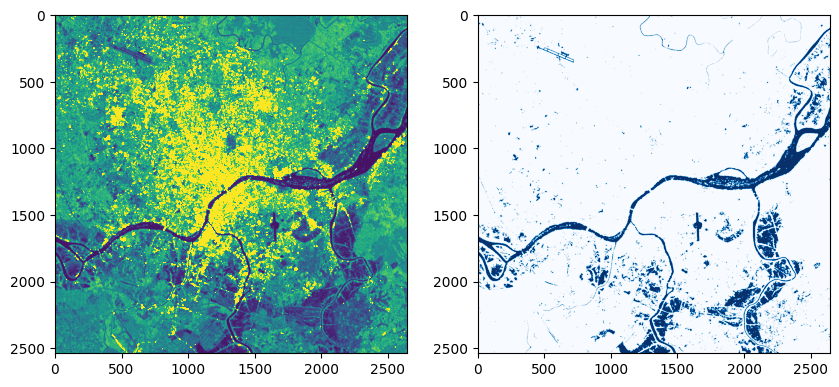

In [99]:
# Create mean image
dry_images_mean = xr.concat(dry_images, 'time').mean(dim='time')
dry_images_mean = uniform_filter(dry_images_mean)

# Plot
plt.figure(figsize=(10, 5))

# Plot dry image Sentinel-1
plt.subplot(1, 2, 1)
plt.imshow(dry_images_mean, vmin=0, vmax=0.1)

# Create water image
water = dry_images_mean <= 0.02

# Plot it
plt.subplot(1, 2, 2)
plt.imshow(water, cmap='Blues')

In [96]:
# Load Sentinel-1 data in wet season
wet_col = client.search(
    collections=['sentinel-1-rtc'],
    bbox=bbox,
    datetime=f'{START_DATE}/{END_DATE}',
    query={ "sar:polarizations": { "eq": ["VV", "VH"] } }
).item_collection()
wet_col

<xarray.DataArray (time: 7, band: 2, y: 2539, x: 2645)> Size: 376MB
array([[[[0.4141047 , 0.41298902, 0.38055313, ..., 0.09184216,
          0.28024378, 0.33886337],
         [0.4981986 , 0.2733938 , 0.25992882, ..., 0.09447507,
          0.26456255, 0.33936188],
         [0.47933885, 0.27814937, 0.21395332, ..., 0.25515825,
          0.29462472, 0.28630236],
         ...,
         [0.06258479, 0.09618292, 0.258223  , ..., 0.12797926,
          0.11604272, 0.16920336],
         [0.05959812, 0.09075556, 0.1751012 , ..., 0.15078661,
          0.13100132, 0.17516267],
         [0.07476771, 0.09512411, 0.1145807 , ..., 0.20873588,
          0.23200883, 0.25369644]],

        [[0.13801247, 0.07720831, 0.04187137, ..., 0.12152092,
          0.09274949, 0.05331572],
         [0.11949468, 0.078222  , 0.0197112 , ..., 0.09877326,
          0.06555951, 0.04251361],
         [0.07707065, 0.04794265, 0.03081788, ..., 0.05512819,
          0.03756613, 0.03047675],
...
         [0.21506424, 0.30222276, 0.32121825, ..., 0.08895069,
          0.08519068, 0.13680398],
         [0.20693034, 0.3155843 , 0.3546711 , ..., 0.15184163,
          0.06514132, 0.09307816],
         [0.14596683, 0.17021634, 0.23540246, ..., 0.23217039,
          0.15120552, 0.08846575]],

        [[0.04471562, 0.05324471, 0.07106223, ..., 0.0279174 ,
          0.0257356 , 0.0447208 ],
         [0.05768126, 0.05846282, 0.08585167, ..., 0.02019287,
          0.03967865, 0.06075176],
         [0.08010323, 0.10158248, 0.14088447, ..., 0.02611581,
          0.03928526, 0.04570153],
         ...,
         [0.06431025, 0.06151302, 0.05640669, ..., 0.04072663,
          0.03853698, 0.04539393],
         [0.07359155, 0.07542015, 0.07182405, ..., 0.03808548,
          0.02336783, 0.04798093],
         [0.05231961, 0.05907493, 0.06270903, ..., 0.04848765,
          0.04277747, 0.06109731]]]], dtype=float32)
Coordinates:
  * band     (band) <U2 16B 'vv' 'vh'
Dimensions without coordinates: time, y, x
Attributes:
    datetime:  2024-02-27T11:24:39.739305Z

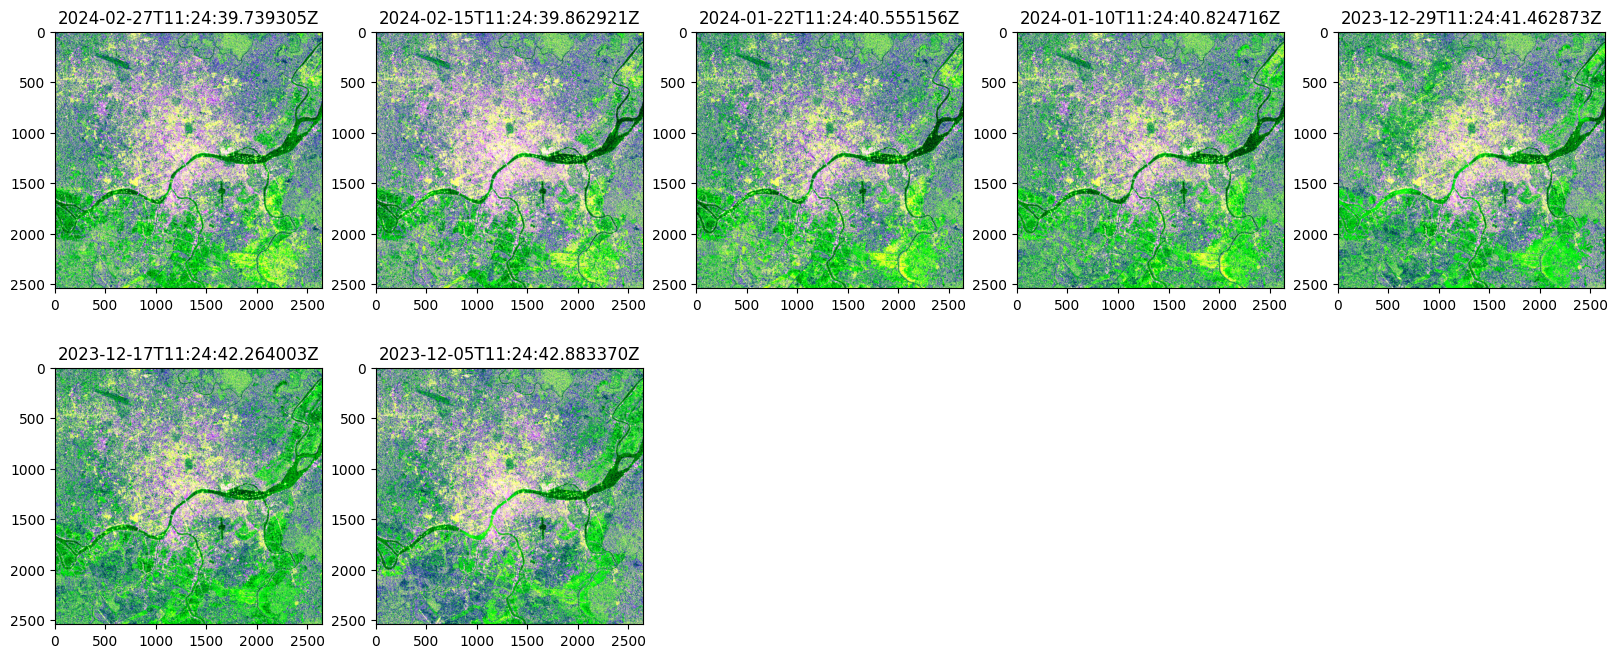

In [97]:
# Show Sentinel-1 data
plt.figure(figsize=(20, 8))

bands = ['vv', 'vh']

s1_images = []
for x in range(0, len(wet_col)):
    item = wet_col[x]
    properties = item.properties
    time = properties['datetime']
    assets = item.assets

    # Load image per bands
    images = []
    for y in bands:
        source = rio.open(assets[y].href)

        crs = source.crs
        nodata = source.nodata
        transform_image = source.transform

        bbox_crs = roi.to_crs(crs).union_all().bounds
        window = windows.from_bounds(*bbox_crs, transform=transform_image)

        # Read image
        image = source.read(1, boundless=True, fill_value=nodata, window=window, out_shape=dem_shape, out_dtype='float32')
        image[image == nodata] = np.nan
        image = xr.DataArray(image, dims=['y', 'x'])

        images.append(image)

    # Combine images of all bands
    images = xr.concat(images, 'band').assign_attrs({ "datetime": time }).assign_coords({ "band": bands })

    # Show images
    vv = images.sel(band='vv')
    vh = images.sel(band='vh')
    rvi = (vv - vh) / (vv + vh)

    # Create composite to show the image
    out_range = (0, 1)
    composite = np.dstack([
        rescale_intensity(vv, in_range=(0.1, 0.4), out_range=out_range),
        rescale_intensity(rvi, in_range=(0.3, 0.75), out_range=out_range),
        rescale_intensity(vh, in_range=(0, 0.1), out_range=out_range)
    ])

    del vv
    del vh
    del rvi

    plt.subplot(2, 5, x + 1)
    plt.imshow(composite)
    plt.title(time)

    s1_images.append(images)

    del images

s1_images = xr.concat(s1_images, 'time')
s1_images

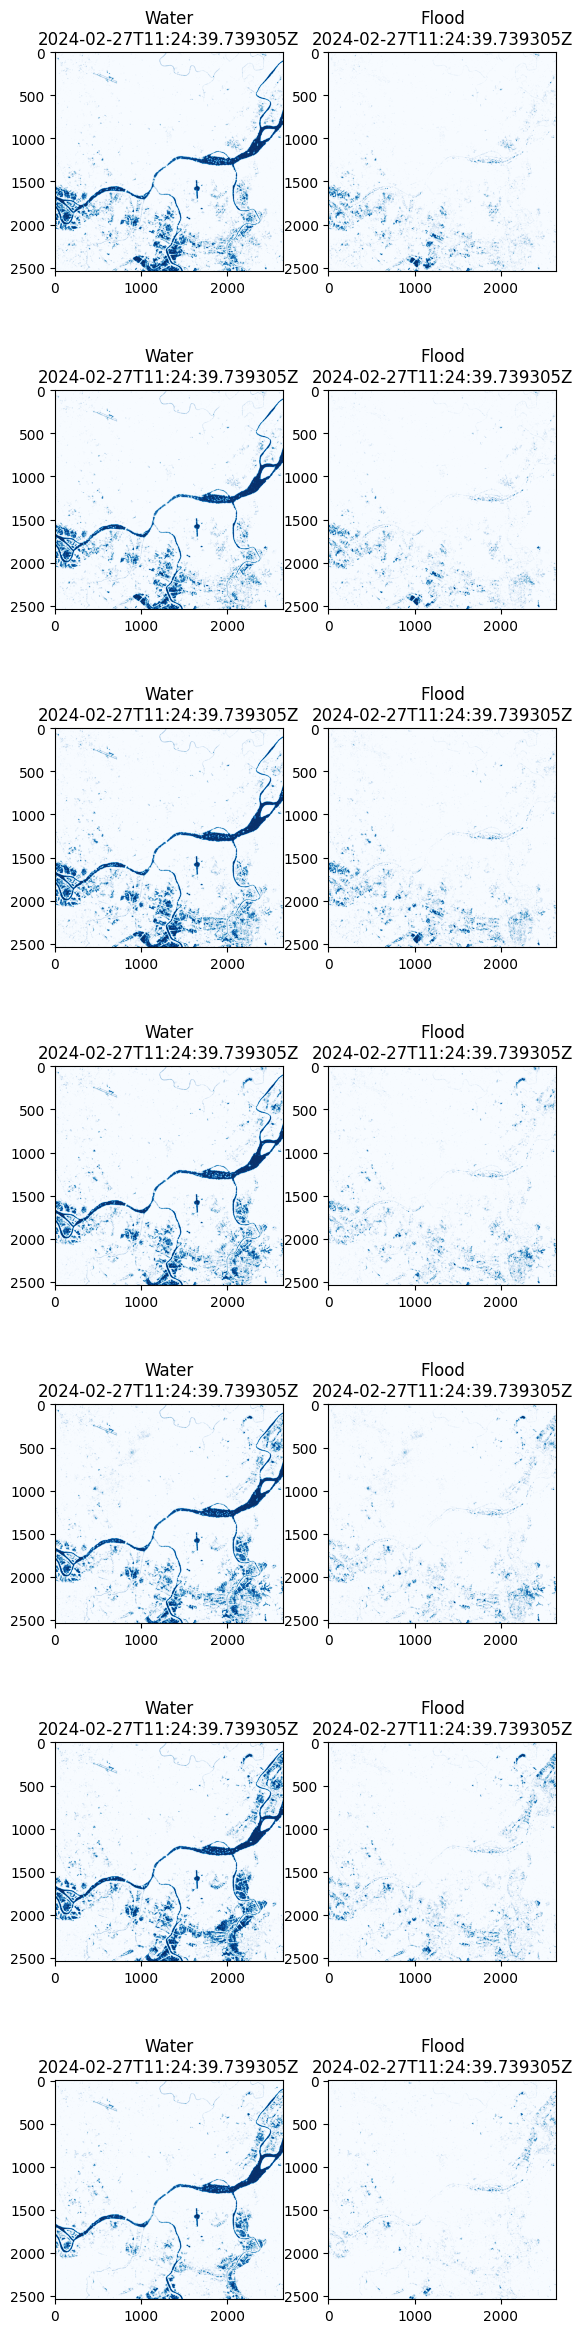

In [100]:
# Map water and flood
plt.figure(figsize=(10, 30))

for x in range(0, len(s1_images)):
    image = s1_images[x]
    time = image.attrs['datetime']
    vv = image.sel(band='vv')
    vh = image.sel(band='vh')

    # Classify water
    water_current = vh <= 0.01

    # Plot water
    plt.subplot(len(s1_images), 3, x * 3 + 1)
    plt.imshow(water_current, cmap='Blues')
    plt.title(f'Water\n{time}')

    # Map flood
    flood = (water_current == 1) & (water == 0)

    # Plot flood
    plt.subplot(len(s1_images), 3, x * 3 + 2)
    plt.imshow(flood, cmap='Blues')
    plt.title(f'Flood\n{time}')